# Principles of Data Science

### Lecture 10: Maximum Likelihood Estimation

_MPhil in Data Intensive Science_

**University of Cambridge**

<h2 style="color: blue">Matt Kenzie</h2>

[mk652@cam.ac.uk](mailto:mk652@cam.ac.uk)

## Maximum Likelihood Estimation

- Today's lecture covers maximum likelihood estimation

- Learning objectives:
  - Understand and be able to compute the likleihood
  - Know the difference between a p.d.f and a likelihood
  - Know that an estimate can be produced by maximising the likelihood
  - Understand the relationship between the likelihood, the score and the minimum variance bound

## Recap


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../mphil.mplstyle')
np.random.seed(210187)

## The likelihood function

- Gives the *likelihood* of observing data $X_i$ given values of parameters $\theta$
- Set of i.i.d observations of $X \sim f(X; \theta)$ 
- Joint p.d.f. of the set $X$ is

$$ p(X | \theta) = \prod_{i=1}^N f(X_i; \theta) $$

- Replacing r.v. $X$ by a set of **observations** $X_0$ means that $p(X_0|\theta)$ is **no longer** a proabibility distribution
- It is now called the **likelihood**:

$$ L(\theta) = p(X_0 | \theta) = \prod_{i=1}^{N} f(X_0|\theta) $$

## Properties of the likelihood function

- **It is not a p.d.f.!!** 
- **It is not** a function of the r.v. $X$ but **a function of the parameters** $\theta$
- We will often write as $L(\theta)$ but can be written $p(X|\theta)$ 
- It tells us the likelihood we see the observations $X_i$ given a the parameter values $\theta$

## A likelihood example

- Let's imagine a set of 250 observations of a normally distributed r.v.

In [1]:
# define the p.d.f. N(1, 2)
from scipy.stats import norm
pdf = norm(loc=1, scale=2)

# generate the data
X_i = pdf.rvs(size=250)

- And let's visualise

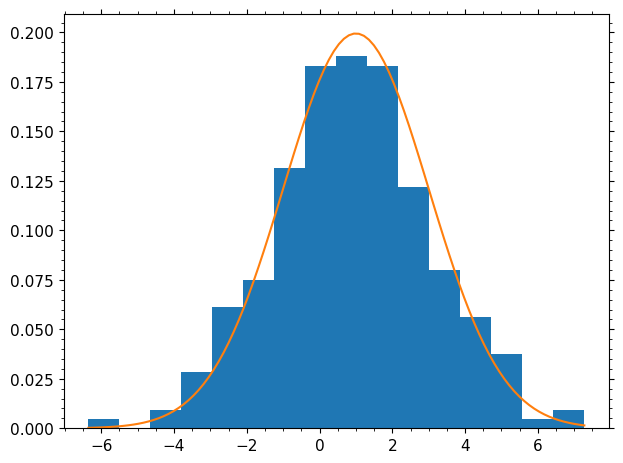

In [3]:
plt.hist( X_i, bins='auto', density=True )
x = np.linspace( np.min(X_i), np.max(X_i), 100 )
plt.plot(x, pdf.pdf(x) )

- Now we will define the likelihood function

In [4]:
# make the likelihood function
def likelihood(mu, sg):
    return np.prod( norm.pdf(X_i, mu, sg) )

- Some things to notice here:
    - the `scipy.stats.norm` function can take an array for the x argument
    - however it expects a scalar for the location and scale (or an array of the same size)
    - we want to always take the product over X_i
    - we are taking the product of numbers $<<1$ so end up with a very small number which is not computationally efficient
    
- So let's code some work-arounds

In [5]:
# re-write the likelihood function based on summing logs
def likelihood(mu, sg) :
    return np.exp( np.sum( norm.logpdf(X_i, mu, sg) ) )

In [6]:
# vectorise the function so we can pass arrays for mu and sigma
vec_likelihood = np.vectorize( likelihood )

Text(0.5, 0.5, '$\\sigma$')

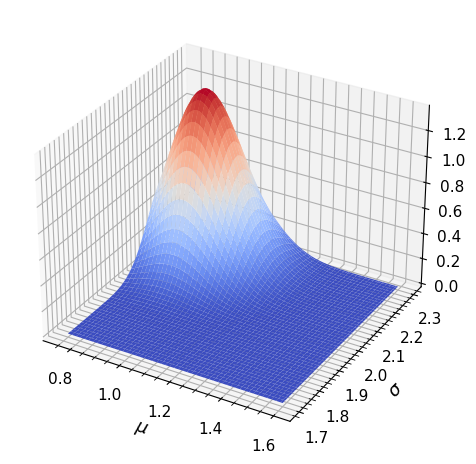

In [7]:
# now draw it
mu = np.linspace(0.75,1.6,100)
sg = np.linspace(1.7,2.3,100)

mu, sg = np.meshgrid(mu, sg)
L = vec_likelihood(mu, sg)

fig, ax = plt.subplots( subplot_kw={"projection":"3d"} )
ax.plot_surface( mu, sg, L, cmap='coolwarm' )
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')

- and can draw the 1D projections assuming a "known" value of the other dimension

Text(0, 0.5, '$L(\\sigma)$')

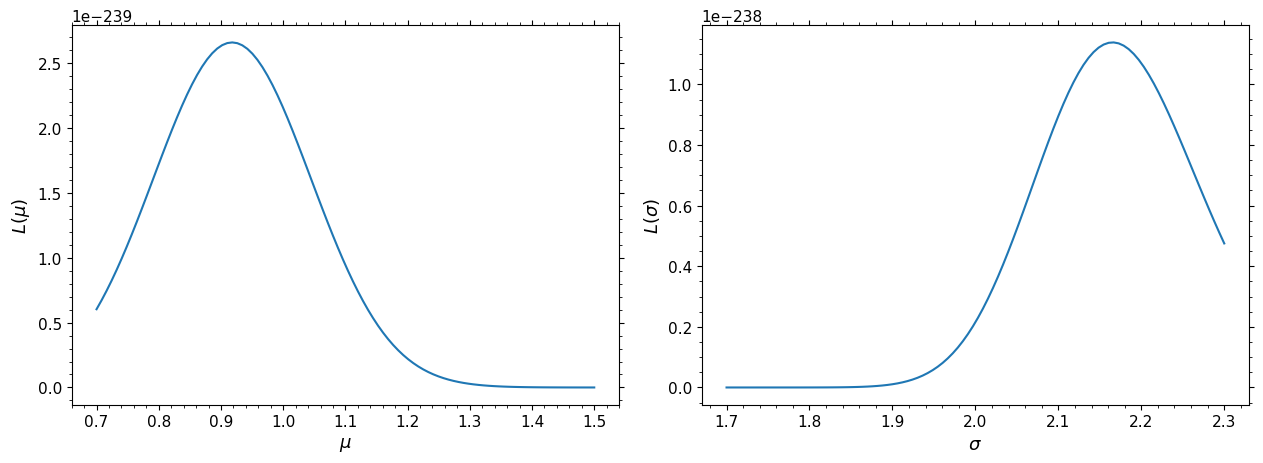

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12.8, 4.8) )

# mu projection
mu = np.linspace(0.7,1.5,100)
sg = np.full_like(mu, 2)
ax[0].plot(mu, vec_likelihood(mu, sg))
ax[0].set_xlabel('$\mu$')
ax[0].set_ylabel('$L(\mu)$')

# sg projection
sg = np.linspace(1.7,2.3,100)
mu = np.full_like(sg, 1)
ax[1].plot(sg, vec_likelihood(mu, sg))
ax[1].set_xlabel('$\sigma$')
ax[1].set_ylabel('$L(\sigma)$')

# <font color="darkred">*Musical interlude...*</font>

## Maximum Likelihood Estimation

- The ML method of estimation provides parameter estimates as those which <font color="blue">*maximise the likelihood*</font>
- ML estimates are in general <font color="green">*biased*</font> however they are <font color="green">*consistent*</font> (so $b \to 0$ as $N\to \infty$)

$$ L(\theta) = \prod_i p(X_i | \theta)  $$

- estimate for $\theta$ can be found from value which maximises $L$

$$ \left. \frac{ \partial L(\theta) }{\partial \theta} \right|_{\theta=\hat{\theta}} = 0 $$

- This is called the <font color="blue">*maximum likelihood estimate (MLE)*</font>


## The log-likelihood

- In practise much easier to work with $\ln L$
    - Product, $\prod$, turns into a sum, $\sum$ (computationally much easier)
- The value of $\hat{\theta}$ that maximises $L$ will also be the one that maximises $\ln L$

$$ \left. \frac{ \partial \ln L(\theta) }{ \partial \theta } \right|_{\theta=\hat{\theta}} = \frac{\partial}{\partial \theta} \sum_{i=1}^{N} \ln p(X_i | \theta) = 0 $$

- For this reason it is very useful to have definitions of the $\ln$ of our p.d.f.s
    - `scipy.stats` has implementations of these
    - many common p.d.f.s contain exponentials so are simpler as the $\ln$ p.d.f
    
- E.g. normal distribution

$$ p(X; \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} exp \left[ - \frac{ (X - \mu) }{ 2\sigma^2} \right] $$

$$ \ln p(X; \mu, \sigma) = - \frac{ (X-\mu) }{2\sigma^2} + C $$

## Minimisation

- In practise, normal procedure is to <font color="blue">*minimise*</font> the negative log-likelihood
- Sometimes this can be solved analytically
- More often than not it needs to be done numerically
- What packages for minimisation?
    - There are a lot
    - For something rather quick and simple I make use of `scipy.optimize` methods (*e.g.* `scipy.optimize.minimize`)
    - For any proper use case I make use of [`iminuit`](https://iminuit.readthedocs.io)

## The score and the information

- For likelihood function, $L(\theta)$, the **score** is defined as

$$ S(\theta) = \frac{ \partial \ln L(\theta) }{ \partial \theta } $$

- Can show that (<font color="green">*proof in the lectures*</font>)

$$ E[S(\theta)] = E\left[ \frac{ \partial \ln L(\theta) }{ \partial \theta } \right] = 0 $$

- Since $E[S(\theta)]=0$ then the variance (which is called the **information**) is

$$ I(\theta) = V \left( S(\theta) \right) = E\left[ S(\theta)^2 \right] = E\left[ \left( \frac{ \partial \ln L(\theta) }{ \partial \theta }\right)^2 \right] $$

- Can show that (<font color="green">*proof in the lectures*</font>)

$$ I(\theta) = - E \left[ \frac{ \partial^2 \ln L(\theta) }{ \partial \theta^2 } \right] $$

## The minimum variance bound

- A very useful property of the likelihood 
- Can show that there is a **limit to the efficiency** of an estimator related to the **likelihood*
    
- The **minimum variance bound** states that

$$ V(\hat{\theta}) \geq  \phantom{-} \biggl( E\biggl[ \left( \frac{\partial \ln L }{\partial \theta } \right)^{2} \biggr] \biggr)^{-1}$$

$$ V(\hat{\theta}) \geq - \biggl( E \biggl[ \left( \frac{ \partial^2 \ln L}{\partial \theta^2} \right) \biggr] \biggr)^{-1} $$

- <font color="green">*proof in the lectures*</font>
- This is an important theorem which we will return to later

*It is also called the Cramer-Rao or Frechet inequality*

## Efficiency of the MLE

- Can show that the variance of the MLE **is** the minimum variance bound when $N\to \infty$
- This means that the ML method **is** efficient as $N\to\infty$
- A beautiful property of the MLE is that

$$ E \left[ \frac{\partial ^2 \ln L}{\partial \theta^2} \right] = \left. \frac{\partial ^2 \ln L}{\partial \theta^2} \right|_{\theta=\hat{\theta}} $$

- And recall that at the minimum variance bound:

$$ V(\hat{\theta}) = -  E \left[ \frac{\partial ^2 \ln L}{\partial \theta^2} \right]^{-1} $$

- This means we can get an <font color="blue">estimate for the variance of my estimate</font> by simply evalauting the double differential of the likelihood at $\theta=\hat{\theta}$

## Uncertainties on estimates

- The above is a **really** powerful property of MLE
- We can essentially get an uncertainty for free (almost)
    - we do still have to compute the double differential of the likelihood
- This is why the [`iminuit`](https://iminuit.readthedocs.io) is so useful 
    - provides an implementation of the `hesse` algorithm
    
- In general if $N$ is large and if $\partial^2 \ln L/ \partial\theta^2$ is slowly varying near $\hat{\theta}$
    - then MLE of $\hat{\theta}$ will be Gaussian distributed with variance at the m.v.b

## Uncertainties on estimates

- Then the log-likelihood will map out a parabola in the parameter space
- Can read the uncertainty directly off the plot (we will see why later)

<img src="plots/log_likelihood.png" alt="drawing" width="600">

# End of Lecture 10

By the end of this lecture you should:
 - Understand and be able to compute the likleihood
 - Know the difference between a p.d.f and a likelihood
 - Know that an estimate can be produced by maximising the likelihood
 - Understand the relationship between the likelihood, the score and the minimum variance bound